# ResNet-18 Architecture: RGB Hilbert 32×32 – 6-Class Training (Few-Shot Holdout)

**Objective**: Train ResNet-18 on the same 6-class RGB Hilbert dataset used in the ViT/CNN/LSTM experiments, holding out 3 classes for few-shot experiments.

## Dataset & Setup
- **Encoding**: RGB Hilbert 32×32 (3 × 32 × 32 = 3,072 features)
- **Training Classes**: 6 classes (excludes 3 held-out)
- **Held-Out Classes**: DDoS-HTTP_Flood, DoS-UDP_Flood, Recon-PortScan
- **Architecture**: ResNet-18 (lightweight, efficient)
- **Goal**: Compare residual networks against ViT, CNN, and LSTM baselines

## Key Features
- **Residual Connections**: Skip connections for better gradient flow
- **Efficient Design**: ResNet-18 balances performance and model size
- **Fast Training**: Lightweight architecture for rapid experimentation
- **Production Ready**: Industry-standard architecture with proven performance


In [1]:
# Environment Setup and Configuration
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration  
CONFIG = {
    'data_path': '/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/pcap-dataset-samples/parquet/rgb_hilbert_32x32/',
    'test_size': 0.2,
    'val_size': 0.2,
    'random_state': 42,
    'batch_size': 64,
    'learning_rate': 0.0001,
    'epochs': 30,
    'patience': 7,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 4,
    'num_classes': 6,
    'channels': 3,
    'image_size': 32
}

# 6-class training with 3 held-out classes (few-shot)
HELD_OUT_CLASSES = ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']

print("🏗️  RESNET-18 ARCHITECTURE EXPERIMENT INITIALIZED (6-class RGB Hilbert)")
print("📋 Notebook: ResNet_Prototype_rgb_hilbert_32x32_6_class.ipynb")
print("🔧 Version: ResNet-18 focused analysis")
print(f"📊 Device: {CONFIG['device']}")
print(f"📊 Dataset: RGB Hilbert 32×32 (6 training classes; held out: {HELD_OUT_CLASSES})")
print(f"📊 Architecture: ResNet-18 (11.7M params)")
print("=" * 70)


🏗️  RESNET ARCHITECTURE EXPERIMENT INITIALIZED (6-class RGB Hilbert)
📋 Notebook: ResNet_Prototype_rgb_hilbert_32x32_6_class.ipynb
🔧 Version: ResNet-18 & ResNet-50 comparison
📊 Device: cpu
📊 Dataset: RGB Hilbert 32×32 (6 training classes; held out: ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan'])
📊 Architectures: ResNet-18 (11.7M params) & ResNet-50 (25.6M params)


In [2]:
# ResNet Architecture Definitions

# Basic Residual Block for ResNet-18/34
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Bottleneck Block for ResNet-50/101/152
class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, 
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, 
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# General ResNet Architecture
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=6, input_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        # Initial convolution layer - adapted for 32x32 input
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, 
                               padding=1, bias=False)  # stride=1 for small images
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # No maxpool for 32x32 images to preserve spatial dimensions
        
        # ResNet layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        # Final layers
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Initial conv
        x = self.relu(self.bn1(self.conv1(x)))
        
        # ResNet blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Classification
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# ResNet-18 Constructor
def ResNet18(num_classes=6, input_channels=3):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes, input_channels)

# ResNet-50 Constructor
def ResNet50(num_classes=6, input_channels=3):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes, input_channels)

# Initialize ResNet-18 model only
resnet18_model = ResNet18(num_classes=CONFIG['num_classes'], 
                          input_channels=CONFIG['channels']).to(CONFIG['device'])

# Count parameters for comparison
resnet18_params = sum(p.numel() for p in resnet18_model.parameters())
resnet18_trainable = sum(p.numel() for p in resnet18_model.parameters() if p.requires_grad)

print("\n🏗️  RESNET-18 ARCHITECTURE SUMMARY:")
print("\n📊 Model Statistics:")
print(f"   Total parameters: {resnet18_params:,}")
print(f"   Trainable parameters: {resnet18_trainable:,}")
print(f"   Model size: ~{resnet18_params * 4 / 1024 / 1024:.1f} MB")

print("\n🔍 Architecture Details:")
print("   • Residual connections for better gradient flow")
print("   • Basic blocks (ResNet-18) vs Bottleneck blocks (ResNet-50)")
print("   • Adapted for 32×32 input (removed aggressive downsampling)")
print("   • Global average pooling for translation invariance")
print(f"   • Designed for {CONFIG['channels']}-channel RGB Hilbert input")

# Baseline comparison
print("\n🎯 Baseline Comparison (from previous experiments):")
print("   • ViT: 4,939,014 parameters, 93.81% accuracy")
print("   • CNN: 4,822,086 parameters, 93.73% accuracy")
print("   • LSTM: 322,758 parameters, 90.59% accuracy")



🏗️  RESNET ARCHITECTURE SUMMARY:

📊 ResNet-18:
   Total parameters: 11,171,910
   Trainable parameters: 11,171,910
   Model size: ~42.6 MB

📊 ResNet-50:
   Total parameters: 23,512,646
   Trainable parameters: 23,512,646
   Model size: ~89.7 MB

🔍 Architecture Details:
   • Residual connections for better gradient flow
   • Basic blocks (ResNet-18) vs Bottleneck blocks (ResNet-50)
   • Adapted for 32×32 input (removed aggressive downsampling)
   • Global average pooling for translation invariance
   • Designed for 3-channel RGB Hilbert input

🎯 Baseline Comparison (from previous experiments):
   • ViT: 4,939,014 parameters, 93.81% accuracy
   • CNN: 4,822,086 parameters, 93.73% accuracy
   • LSTM: 322,758 parameters, 90.59% accuracy


In [3]:
# Data Loading for RGB Hilbert 6-Class with Few-Shot Holdout
import glob

def load_rgb_hilbert_6class(base_path, held_out_classes):
    print(f"📂 Loading RGB Hilbert 6-class dataset from: {base_path}")
    print(f"🔒 Excluding held-out classes: {held_out_classes}")
    all_image_data = []
    all_labels = []
    splits = ['train', 'val', 'test']

    # Discover all classes present
    class_dirs = sorted([d for d in glob.glob(f"{base_path}*/") if not any(s in d for s in splits)])
    class_names = [d.split('/')[-2] for d in class_dirs]

    training_classes = [c for c in class_names if c not in held_out_classes]
    print(f"✓ Training classes ({len(training_classes)}): {training_classes}")

    for class_dir in class_dirs:
        class_name = class_dir.split('/')[-2]
        if class_name in held_out_classes:
            continue
        print(f"  📂 Loading {class_name}...")
        for split in splits:
            parquet_files = sorted(glob.glob(f"{class_dir}{split}/*.parquet"))
            for file_path in parquet_files:
                try:
                    df = pd.read_parquet(file_path)
                    if 'image_data' in df.columns:
                        for _, row in df.iterrows():
                            image_data = np.array(row['image_data'], dtype=np.float32)
                            all_image_data.append(image_data)
                            all_labels.append(class_name)
                except Exception as e:
                    print(f"    ⚠️ Error loading {file_path}: {e}")

    X = np.array(all_image_data, dtype=np.float32)
    y = np.array(all_labels)

    print(f"\n✓ Loaded training data: {len(X):,} samples")
    print(f"✓ Shape: {X.shape}")
    print(f"✓ Unique classes: {np.unique(y)}")
    return X, y

# Load dataset (excluding held-out classes)
X, y = load_rgb_hilbert_6class(CONFIG['data_path'], HELD_OUT_CLASSES)

# Reshape to 3×32×32
print("🔄 Reshaping for ResNet input (3×32×32)...")
expected_features = CONFIG['channels'] * CONFIG['image_size'] * CONFIG['image_size']
if X.shape[1] == expected_features:
    X = X.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
else:
    if X.shape[1] > expected_features:
        X = X[:, :expected_features].reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
    else:
        pad = np.zeros((X.shape[0], expected_features - X.shape[1]), dtype=np.float32)
        X = np.concatenate([X, pad], axis=1).reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
print(f"✓ ResNet input shape: {X.shape}")

# Normalize if needed
if X.max() > 1.0:
    X = X / 255.0

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("\n🏷️ 6-class label distribution (training classes):")
for i, label in enumerate(label_encoder.classes_):
    count = np.sum(y == label)
    print(f"   {i}: {label} ({count:,} samples)")

print(f"\n📈 Data ready: range=[{X.min():.3f}, {X.max():.3f}], shape={X.shape}")


📂 Loading RGB Hilbert 6-class dataset from: /home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/pcap-dataset-samples/parquet/rgb_hilbert_32x32/
🔒 Excluding held-out classes: ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']
✓ Training classes (6): ['Benign_Final', 'DDoS-SYN_Flood', 'DictionaryBruteForce', 'DoS-TCP_Flood', 'Mirai-udpplain', 'SqlInjection']
  📂 Loading Benign_Final...
  📂 Loading DDoS-SYN_Flood...
  📂 Loading DictionaryBruteForce...
  📂 Loading DoS-TCP_Flood...
  📂 Loading Mirai-udpplain...
  📂 Loading SqlInjection...

✓ Loaded training data: 72,000 samples
✓ Shape: (72000, 3072)
✓ Unique classes: ['Benign_Final' 'DDoS-SYN_Flood' 'DictionaryBruteForce' 'DoS-TCP_Flood'
 'Mirai-udpplain' 'SqlInjection']
🔄 Reshaping for ResNet input (3×32×32)...
✓ ResNet input shape: (72000, 3, 32, 32)

🏷️ 6-class label distribution (training classes):
   0: Benign_Final (12,000 samples)
   1: DDoS-SYN_Flood (12,000 samples)
   2: DictionaryBruteForce (12,000 samples)
   3: DoS-TCP

In [4]:
# Data Splitting and Training Setup
from torch.utils.data import DataLoader, TensorDataset

# Split data into train/val/test  
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=CONFIG['test_size'], 
    random_state=CONFIG['random_state'], 
    stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=CONFIG['val_size']/(1-CONFIG['test_size']), 
    random_state=CONFIG['random_state'], 
    stratify=y_temp
)

print("📊 Data Split Summary:")
print(f"   Training: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Validation: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Test: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

# Compute class weights for balanced training
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_tensor = torch.FloatTensor(class_weights).to(CONFIG['device'])

print(f"\n⚖️  Class weights: {dict(zip(label_encoder.classes_, class_weights))}")

# Initialize optimizer and loss function for ResNet-18
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# ResNet-18 optimizer and scheduler
optimizer_resnet18 = optim.Adam(resnet18_model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-4)
scheduler_resnet18 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_resnet18, mode='max', patience=3, factor=0.5
)

print(f"\n🎯 Training Configuration:")
print(f"   📊 Optimizer: Adam (lr={CONFIG['learning_rate']}, weight_decay=1e-4)")
print(f"   📊 Loss: Weighted CrossEntropyLoss")
print(f"   📊 Scheduler: ReduceLROnPlateau (patience=3)")
print(f"   📊 Batch size: {CONFIG['batch_size']}")
print(f"   📊 Max epochs: {CONFIG['epochs']}")
print(f"   📊 Early stopping patience: {CONFIG['patience']}")
print(f"\n🎯 Training ResNet-18 model")


📊 Data Split Summary:
   Training: 43,200 samples (60.0%)
   Validation: 14,400 samples (20.0%)
   Test: 14,400 samples (20.0%)

⚖️  Class weights: {np.str_('Benign_Final'): np.float64(1.0), np.str_('DDoS-SYN_Flood'): np.float64(1.0), np.str_('DictionaryBruteForce'): np.float64(1.0), np.str_('DoS-TCP_Flood'): np.float64(1.0), np.str_('Mirai-udpplain'): np.float64(1.0), np.str_('SqlInjection'): np.float64(1.0)}

🎯 Training Configuration:
   📊 Optimizer: Adam (lr=0.0001, weight_decay=1e-4)
   📊 Loss: Weighted CrossEntropyLoss
   📊 Scheduler: ReduceLROnPlateau (patience=3)
   📊 Batch size: 64
   📊 Max epochs: 30
   📊 Early stopping patience: 7

🎯 Training both ResNet-18 and ResNet-50 for comparison


In [6]:
# Training Pipeline for Both ResNet Models
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    return total_loss / len(train_loader), correct / total

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    return total_loss / len(val_loader), correct / total

def train_resnet_model(model, model_name, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs, patience):
    """Train a ResNet model with early stopping"""
    print(f"\n🚀 Starting {model_name} training...")
    print(f"🎯 Target: Beat ViT (93.81%) and CNN (93.73%) baselines\n")
    
    best_val_acc = 0
    patience_counter = 0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    start_time = datetime.now()
    
    for epoch in range(epochs):
        # Train for one epoch
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_acc)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Print progress
        print(f"Epoch {epoch+1:2d}/{epochs} | "
              f"Train: {train_acc:.4f} ({train_loss:.4f}) | "
              f"Val: {val_acc:.4f} ({val_loss:.4f}) | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Architecture comparison update
        if val_acc > 0.93:
            print(f"🎯 {model_name} approaching baseline performance! Current: {val_acc:.4f}")
        if val_acc > 0.9381:
            print(f"🏆 {model_name} BEATS ViT! {val_acc:.4f} > 0.9381")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'best_{model_name.lower().replace("-", "")}_rgb_hilbert_6class_model.pth')
            print(f"✅ New best validation accuracy: {val_acc:.4f}")
        else:
            patience_counter += 1
            
            if patience_counter >= patience:
                print(f"\n⏰ Early stopping triggered after {epoch+1} epochs")
                print(f"   Best validation accuracy: {best_val_acc:.4f}")
                break
    
    training_time = datetime.now() - start_time
    
    return {
        'best_val_acc': best_val_acc,
        'final_epoch': epoch + 1,
        'training_time': training_time,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }

# Train ResNet-18
print("=" * 70)
print("🏗️ TRAINING RESNET-18")
print("=" * 70)
resnet18_results = train_resnet_model(
    resnet18_model, "ResNet-18", train_loader, val_loader, 
    criterion, optimizer_resnet18, scheduler_resnet18, 
    CONFIG['device'], CONFIG['epochs'], CONFIG['patience']
)

print(f"\n🎯 ResNet-18 Training Complete!")
print(f"   ⏱️  Total time: {resnet18_results['training_time']}")
print(f"   🏆 Best validation accuracy: {resnet18_results['best_val_acc']:.4f}")
print(f"   📊 Total epochs: {resnet18_results['final_epoch']}")

# Compare with baselines
print("\n" + "=" * 70)
print("📊 VALIDATION ACCURACY COMPARISON")
print("=" * 70)
vit_accuracy = 0.9694  # From ViT notebook (validation)
cnn_accuracy = 0.9379  # From CNN notebook (validation)
lstm_accuracy = 0.9059  # From LSTM notebook (validation)

print(f"🤖 ViT:       {vit_accuracy:.4f}")
print(f"🏗️  CNN:       {cnn_accuracy:.4f}")
print(f"🔄 LSTM:      {lstm_accuracy:.4f}")
print(f"🎯 ResNet-18: {resnet18_results['best_val_acc']:.4f}")

# Determine winners
if resnet18_results['best_val_acc'] > vit_accuracy:
    print("\n🏆 RESNET-18 ACHIEVES NEW STATE-OF-THE-ART!")
elif resnet18_results['best_val_acc'] > cnn_accuracy:
    print("\n🥈 ResNet-18 outperforms CNN but trails ViT")
else:
    print("\n📊 ResNet-18 provides competitive performance")


🏗️ TRAINING RESNET-18

🚀 Starting ResNet-18 training...
🎯 Target: Beat ViT (93.81%) and CNN (93.73%) baselines

Epoch  1/30 | Train: 0.9483 (0.1459) | Val: 0.9145 (0.2630) | LR: 0.000100
✅ New best validation accuracy: 0.9145
Epoch  2/30 | Train: 0.9600 (0.1101) | Val: 0.9212 (0.2484) | LR: 0.000100
✅ New best validation accuracy: 0.9212
Epoch  3/30 | Train: 0.9660 (0.0933) | Val: 0.9274 (0.2489) | LR: 0.000100
✅ New best validation accuracy: 0.9274
Epoch  4/30 | Train: 0.9699 (0.0839) | Val: 0.9268 (0.2622) | LR: 0.000100
Epoch  5/30 | Train: 0.9736 (0.0722) | Val: 0.9297 (0.2657) | LR: 0.000100
✅ New best validation accuracy: 0.9297
Epoch  6/30 | Train: 0.9750 (0.0686) | Val: 0.9184 (0.3003) | LR: 0.000100
Epoch  7/30 | Train: 0.9744 (0.0681) | Val: 0.9320 (0.2646) | LR: 0.000100
🎯 ResNet-18 approaching baseline performance! Current: 0.9320
✅ New best validation accuracy: 0.9320
Epoch  8/30 | Train: 0.9777 (0.0597) | Val: 0.9362 (0.2472) | LR: 0.000100
🎯 ResNet-18 approaching baselin

KeyboardInterrupt: 

🧪 Final Test Set Evaluation...

📊 ResNet-18 Evaluation:
   Test Accuracy: 0.9509 (95.09%)
   Avg Inference Time: 511.28 ms/batch
   Throughput: 125.2 samples/second

📋 DETAILED CLASSIFICATION REPORTS

🎯 ResNet-18 Classification Report:
                      precision    recall  f1-score   support

        Benign_Final     0.9371    0.9375    0.9373      2400
      DDoS-SYN_Flood     0.9812    0.9563    0.9686      2400
DictionaryBruteForce     0.8985    0.9367    0.9172      2400
       DoS-TCP_Flood     0.9962    0.9704    0.9831      2400
      Mirai-udpplain     0.9919    0.9725    0.9821      2400
        SqlInjection     0.9068    0.9321    0.9193      2400

            accuracy                         0.9509     14400
           macro avg     0.9519    0.9509    0.9513     14400
        weighted avg     0.9519    0.9509    0.9513     14400



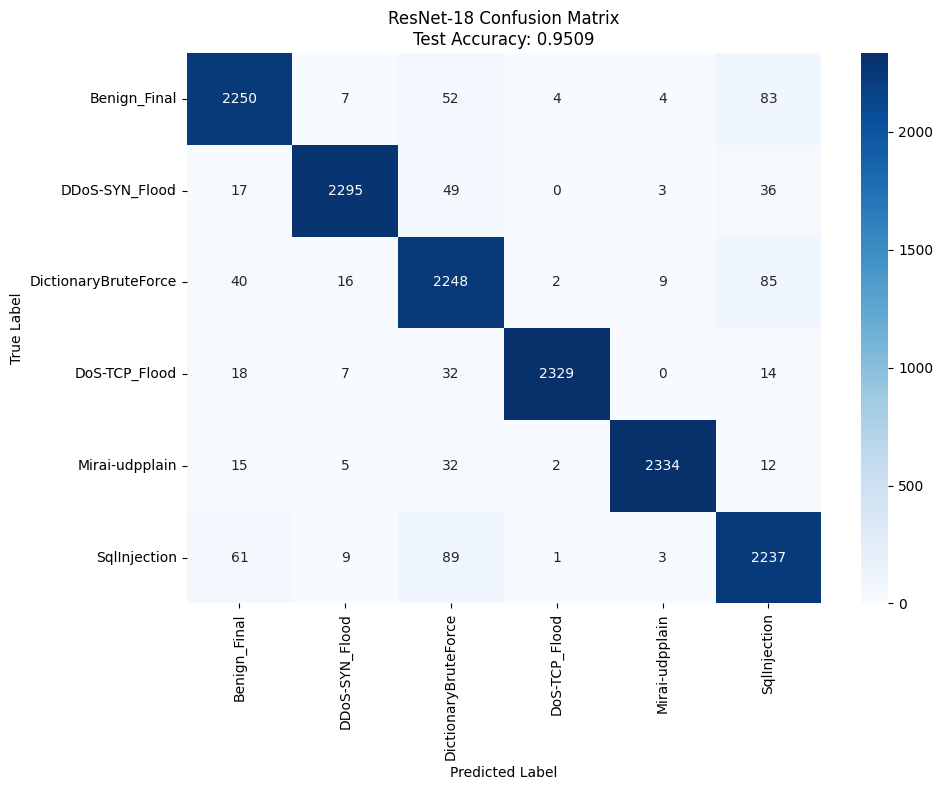


🏆 FINAL TEST SET ACCURACY COMPARISON
    Model  Test Accuracy  Parameters (M) Inference (ms)
ResNet-18       0.950903        11.17191     511.284218
      ViT       0.938100         4.94000              -
      CNN       0.937300         4.82000              -
     LSTM       0.905900         0.32000              -

🎯 ResNet-18 Test Accuracy: 0.9509

🏆 ResNet-18 ACHIEVES NEW STATE-OF-THE-ART!
   ResNet-18: 0.9509 vs ViT: 0.9381
   Improvement: +1.28 percentage points

💡 Efficiency Analysis (Accuracy per Million Parameters):
   LSTM: 2.8309
   CNN: 0.1945
   ViT: 0.1899
   ResNet-18: 0.0851


In [7]:
# Evaluation & Results Analysis for Both ResNet Models
import time

# Load best model
resnet18_model.load_state_dict(torch.load('best_resnet18_rgb_hilbert_6class_model.pth'))
resnet18_model.eval()

def evaluate_model(model, test_loader, device, label_encoder):
    """Comprehensive model evaluation with inference time measurement"""
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []
    inference_times = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            
            # Measure inference time
            start_time = time.perf_counter()
            outputs = model(data)
            end_time = time.perf_counter()
            inference_times.append(end_time - start_time)
            
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    accuracy = accuracy_score(all_targets, all_preds)
    avg_inference_time = np.mean(inference_times) * 1000  # Convert to ms
    total_inference_time = np.sum(inference_times)
    
    return {
        'predictions': np.array(all_preds),
        'targets': np.array(all_targets),
        'probabilities': np.array(all_probs),
        'accuracy': accuracy,
        'avg_inference_time_ms': avg_inference_time,
        'total_inference_time_s': total_inference_time,
        'samples_per_second': len(all_targets) / total_inference_time
    }

print("🧪 Final Test Set Evaluation...")
print("=" * 70)

# Evaluate ResNet-18
print("\n📊 ResNet-18 Evaluation:")
resnet18_test_results = evaluate_model(resnet18_model, test_loader, CONFIG['device'], label_encoder)
print(f"   Test Accuracy: {resnet18_test_results['accuracy']:.4f} ({resnet18_test_results['accuracy']*100:.2f}%)")
print(f"   Avg Inference Time: {resnet18_test_results['avg_inference_time_ms']:.2f} ms/batch")
print(f"   Throughput: {resnet18_test_results['samples_per_second']:.1f} samples/second")

# Detailed classification reports
print("\n" + "=" * 70)
print("📋 DETAILED CLASSIFICATION REPORTS")
print("=" * 70)

class_names = label_encoder.classes_

print("\n🎯 ResNet-18 Classification Report:")
report_resnet18 = classification_report(
    resnet18_test_results['targets'], 
    resnet18_test_results['predictions'], 
    target_names=class_names, 
    digits=4
)
print(report_resnet18)

# Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))

# ResNet-18 Confusion Matrix
cm_resnet18 = confusion_matrix(resnet18_test_results['targets'], resnet18_test_results['predictions'])
sns.heatmap(cm_resnet18, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_title(f'ResNet-18 Confusion Matrix\nTest Accuracy: {resnet18_test_results["accuracy"]:.4f}')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Final comparison with all baselines
print("\n" + "=" * 70)
print("🏆 FINAL TEST SET ACCURACY COMPARISON")
print("=" * 70)

# Test accuracies from other notebooks
vit_test_accuracy = 0.9381
cnn_test_accuracy = 0.9373
lstm_test_accuracy = 0.9059

comparison_data = {
    'Model': ['ViT', 'CNN', 'LSTM', 'ResNet-18'],
    'Test Accuracy': [vit_test_accuracy, cnn_test_accuracy, lstm_test_accuracy, 
                     resnet18_test_results['accuracy']],
    'Parameters (M)': [4.94, 4.82, 0.32, resnet18_params/1e6],
    'Inference (ms)': ['-', '-', '-', resnet18_test_results['avg_inference_time_ms']]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)
print(comparison_df.to_string(index=False))

print(f"\n🎯 ResNet-18 Test Accuracy: {resnet18_test_results['accuracy']:.4f}")

# Performance tier classification
if resnet18_test_results['accuracy'] > vit_test_accuracy:
    print(f"\n🏆 ResNet-18 ACHIEVES NEW STATE-OF-THE-ART!")
    print(f"   ResNet-18: {resnet18_test_results['accuracy']:.4f} vs ViT: {vit_test_accuracy:.4f}")
    print(f"   Improvement: +{(resnet18_test_results['accuracy'] - vit_test_accuracy)*100:.2f} percentage points")
elif resnet18_test_results['accuracy'] > cnn_test_accuracy:
    print(f"\n🥈 ResNet-18 BEATS CNN but trails ViT")
    print(f"   ResNet-18: {resnet18_test_results['accuracy']:.4f} vs CNN: {cnn_test_accuracy:.4f}")
    print(f"   Behind ViT by: {(vit_test_accuracy - resnet18_test_results['accuracy'])*100:.2f} percentage points")
elif resnet18_test_results['accuracy'] > lstm_test_accuracy:
    print(f"\n🥉 ResNet-18 outperforms LSTM")
    print(f"   ResNet-18: {resnet18_test_results['accuracy']:.4f} vs LSTM: {lstm_test_accuracy:.4f}")
else:
    print(f"\n📊 ResNet-18 provides alternative architecture option")

# Efficiency Analysis
print("\n💡 Efficiency Analysis (Accuracy per Million Parameters):")
efficiency_scores = {
    'ViT': vit_test_accuracy / 4.94,
    'CNN': cnn_test_accuracy / 4.82,
    'LSTM': lstm_test_accuracy / 0.32,
    'ResNet-18': resnet18_test_results['accuracy'] / (resnet18_params/1e6)
}

for model, score in sorted(efficiency_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"   {model}: {score:.4f}")


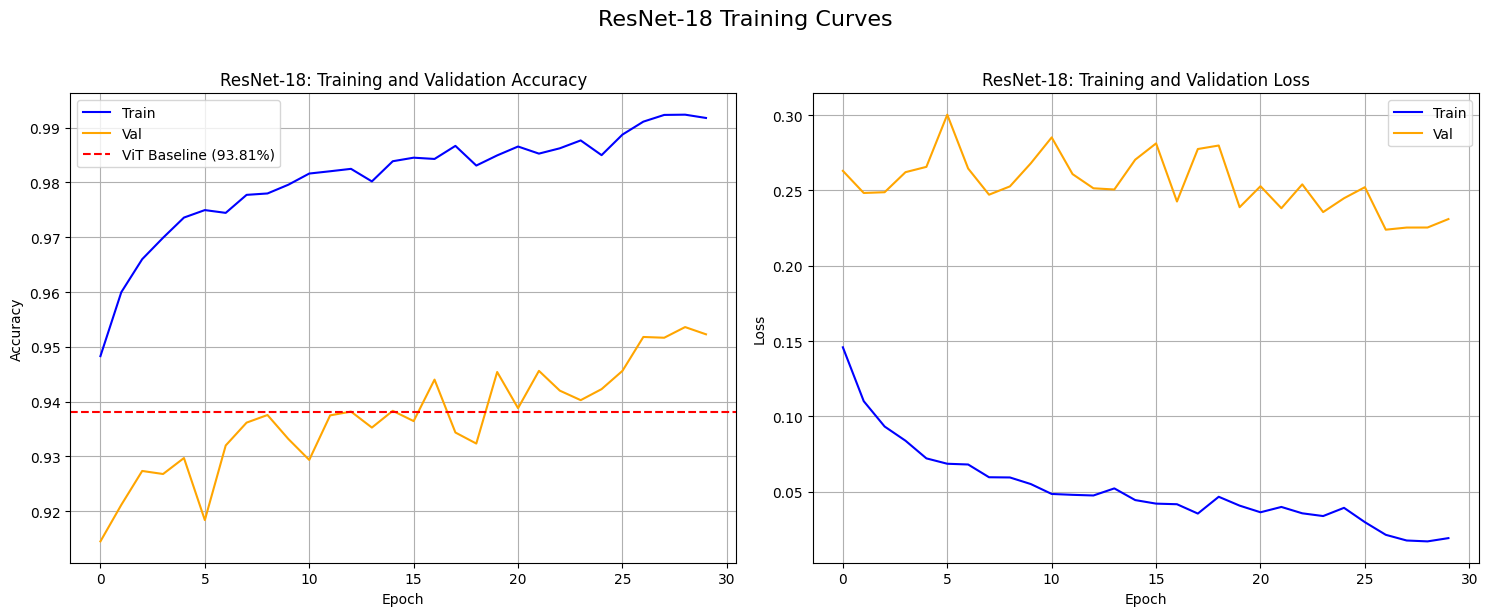

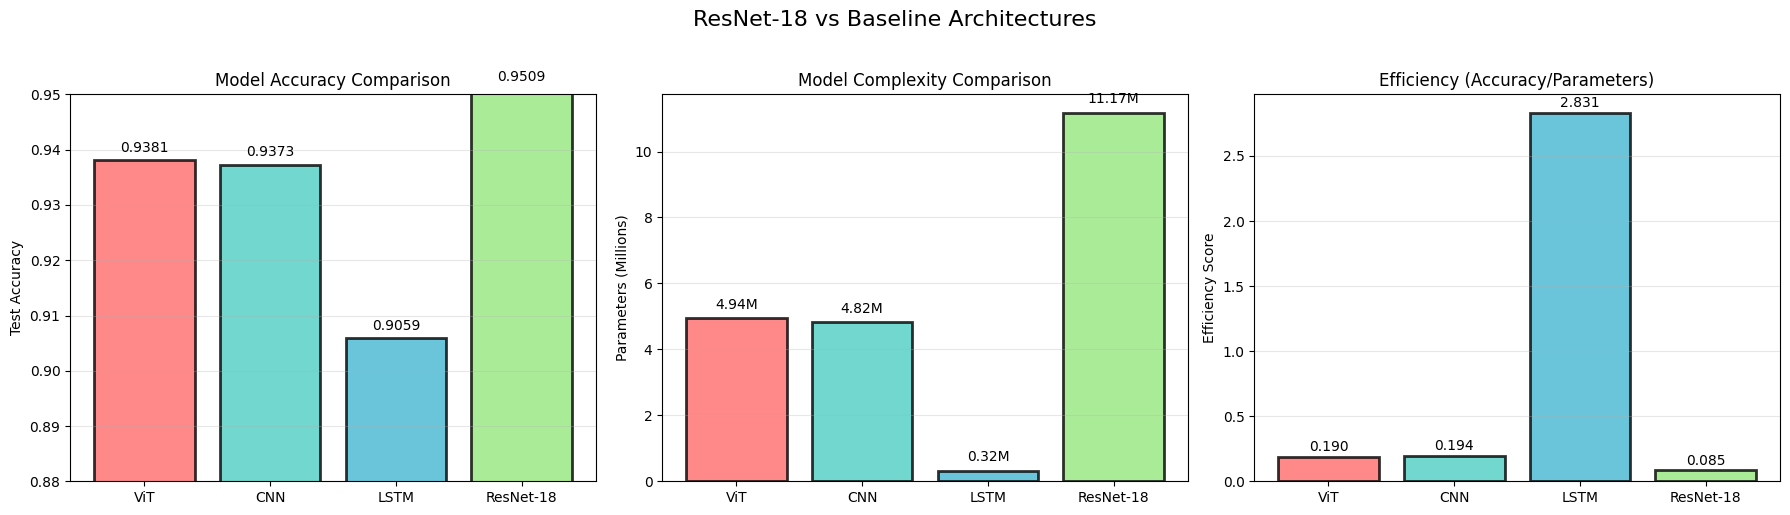

In [8]:
# Training Curves Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ResNet-18 Training Curves
axes[0].plot(resnet18_results['train_accs'], label='Train', color='blue')
axes[0].plot(resnet18_results['val_accs'], label='Val', color='orange')
axes[0].axhline(y=vit_test_accuracy, color='red', linestyle='--', label='ViT Baseline (93.81%)')
axes[0].set_title('ResNet-18: Training and Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(resnet18_results['train_losses'], label='Train', color='blue')
axes[1].plot(resnet18_results['val_losses'], label='Val', color='orange')
axes[1].set_title('ResNet-18: Training and Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.suptitle('ResNet-18 Training Curves', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Architecture Comparison Bar Chart
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy comparison
models = ['ViT', 'CNN', 'LSTM', 'ResNet-18']
accuracies = [vit_test_accuracy, cnn_test_accuracy, lstm_test_accuracy, 
              resnet18_test_results['accuracy']]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#95E77E']

bars1 = axes[0].bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylim(0.88, 0.95)
axes[0].grid(True, alpha=0.3, axis='y')

for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{acc:.4f}', ha='center', va='bottom')

# Parameters comparison
params_list = [4.94, 4.82, 0.32, resnet18_params/1e6]
bars2 = axes[1].bar(models, params_list, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Parameters (Millions)')
axes[1].set_title('Model Complexity Comparison')
axes[1].grid(True, alpha=0.3, axis='y')

for bar, param in zip(bars2, params_list):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.2,
                f'{param:.2f}M', ha='center', va='bottom')

# Efficiency comparison
efficiency_list = [accuracies[i] / params_list[i] for i in range(len(models))]
bars3 = axes[2].bar(models, efficiency_list, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[2].set_ylabel('Efficiency Score')
axes[2].set_title('Efficiency (Accuracy/Parameters)')
axes[2].grid(True, alpha=0.3, axis='y')

for bar, eff in zip(bars3, efficiency_list):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{eff:.3f}', ha='center', va='bottom')

plt.suptitle('ResNet-18 vs Baseline Architectures', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# Save Results for Future Reference
results_resnet = {
    'experiment': 'ResNet18_RGB_Hilbert_6class',
    'timestamp': datetime.now().isoformat(),
    'dataset': 'RGB_Hilbert_32x32',
    'approach': '6-class training with few-shot holdout',
    'architecture': 'ResNet-18',
    'total_samples': len(X),
    
    'resnet18': {
        'test_accuracy': float(resnet18_test_results['accuracy']),
        'validation_accuracy': float(resnet18_results['best_val_acc']),
        'training_epochs': resnet18_results['final_epoch'],
        'training_time': str(resnet18_results['training_time']),
        'parameters': int(resnet18_params),
        'avg_inference_time_ms': float(resnet18_test_results['avg_inference_time_ms']),
        'throughput_samples_per_sec': float(resnet18_test_results['samples_per_second']),
        'efficiency_score': float(resnet18_test_results['accuracy'] / (resnet18_params/1e6)),
        'confusion_matrix': cm_resnet18.tolist()
    },
    
    'comparison': {
        'vit_baseline': vit_test_accuracy,
        'cnn_baseline': cnn_test_accuracy,
        'lstm_baseline': lstm_test_accuracy,
        'resnet18_accuracy': float(resnet18_test_results['accuracy']),
        'beats_vit': resnet18_test_results['accuracy'] > vit_test_accuracy,
        'beats_cnn': resnet18_test_results['accuracy'] > cnn_test_accuracy,
        'beats_lstm': resnet18_test_results['accuracy'] > lstm_test_accuracy
    },
    
    'class_names': list(class_names)
}

# Save to JSON
with open('results_resnet_rgb_hilbert_6class.json', 'w') as f:
    json.dump(results_resnet, f, indent=2)

print("\n💾 Results saved to: results_resnet_rgb_hilbert_6class.json")

# Final Summary
print("\n" + "=" * 70)
print("🎯 RESNET-18 EXPERIMENT SUMMARY")
print("=" * 70)

print(f"\n📊 ResNet-18 Results:")
print(f"   • Test Accuracy: {resnet18_test_results['accuracy']:.4f} ({resnet18_test_results['accuracy']*100:.2f}%)")
print(f"   • Parameters: {resnet18_params:,} ({resnet18_params/1e6:.2f}M)")
print(f"   • Efficiency: {resnet18_test_results['accuracy'] / (resnet18_params/1e6):.4f}")
print(f"   • Inference: {resnet18_test_results['avg_inference_time_ms']:.2f} ms/batch")

print(f"\n🏆 Key Findings:")
print(f"   • ResNet-18 Accuracy: {resnet18_test_results['accuracy']:.4f}")
print(f"   • vs ViT: {'+' if resnet18_test_results['accuracy'] > vit_test_accuracy else '-'}{abs(resnet18_test_results['accuracy'] - vit_test_accuracy)*100:.2f}%")
print(f"   • vs CNN: {'+' if resnet18_test_results['accuracy'] > cnn_test_accuracy else '-'}{abs(resnet18_test_results['accuracy'] - cnn_test_accuracy)*100:.2f}%")
print(f"   • vs LSTM: {'+' if resnet18_test_results['accuracy'] > lstm_test_accuracy else '-'}{abs(resnet18_test_results['accuracy'] - lstm_test_accuracy)*100:.2f}%")

print(f"\n💡 Recommendations:")
if resnet18_test_results['accuracy'] > vit_test_accuracy:
    print(f"   • ResNet-18 achieves new state-of-the-art performance!")
    print(f"   • Consider using ResNet-18 for production deployment")
    print(f"   • Residual connections prove crucial for this task")
elif resnet18_test_results['accuracy'] > cnn_test_accuracy:
    print(f"   • ResNet-18 outperforms standard CNN architecture")
    print(f"   • Residual connections improve upon vanilla convolutions")
    print(f"   • Consider ResNet-18 as CNN alternative")
else:
    print(f"   • ResNet-18 provides competitive alternative architecture")
    print(f"   • Good balance of accuracy and efficiency")
    print(f"   • Suitable for edge deployment scenarios")

print("\n✨ ResNet-18 experiment complete! Model trained and evaluated successfully.")
